# 국민동의청원 데이터 수집하기
- 🐰사이트 URL (모든 청원) : https://petitions.assembly.go.kr/closed/agreeEnded

- 🐰 requests url : inspect > network > header > RequestURL

- 🐰 inspect > Network에서 requests Headers를 확인해보면 'Accept: application/json, text/plain, */*'으로 나타난다. 
     
    - json 타입으로 데이터를 받기 위해 json()을 사용 

## 라이브러리 불러오기

In [30]:
import pandas as pd
import requests
import time
import datetime 
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns

## 쿼리 값 세팅

In [3]:
headers = {"user-agent": "Mozilla/5.0"}
page_no = 1
count_per_page = 8

# 기간은 2022-01-01 ~ 2022-12-31으로 고정
begin_date = 20220101
end_date = 20221231

## url 세팅

In [4]:
base_url = f'https://petitions.assembly.go.kr/api/petits?pageIndex={page_no}&recordCountPerPage={count_per_page}&sort=AGRE_END_DE-&searchCondition=sj&searchKeyword=&petitRealmCode=&sttusCode='
base_url = f'{base_url}PETIT_FORMATN,CMIT_FRWRD,PETIT_END&resultCode=BFE_OTHBC_WTHDRAW,PROGRS_WTHDRAW,PETIT_UNACPT,APPRVL_END_DSUSE,ETC_TRNSF&notInColumn='
base_url = f'{base_url}RESULT_CODE&beginDate={begin_date}&endDate={end_date}&ageCd='


## GET OK 200 확인

In [5]:
base_response = requests.get(base_url, headers=headers)
base_response.status_code

200

## Columns 매핑

In [6]:
col = ["petrNm", "petitSj", "petitObjet", "petitCn", 
     "petitRealmNm", "resultCodeNm","petitEndDt", "agreBeginDe", "agreEndDe", "agreCo"]


columns={"petrNm":"청원인", "petitSj": "청원명", "petitObjet":"청원의 취지",
        "petitCn":"청원의 내용", "petitRealmNm":"청원분야", 
        "resultCodeNm":"청원결과","petitEndDt":"청원종료일", 
        "agreBeginDe":"청원동의시작일", "agreEndDe":"청원동의종료일", "agreCo":"청원 동의수"}

## 한 페이지 내용을 가져오는 함수
- 🐰 앞에서 일일히 각 항목의 리스트를 구하면 데이터 수집하는데 시간이 너무 오래걸리는 것을 확인했다.

- 🐰 각 게시물 페이지 안에서 청원의 취지를 포함한 데이터를 한번에 구한다.

- 🐰 게시물의 url을 이용하여 반복문을 돌릴 때 enumerate를 사용하여 간결하게 한다.

- 🐰 결과적으로 반복문은 1개로 끝낼 수 있어 함수를 돌리는 시간을 많이 단축시킬 수 있었다.

In [7]:
# 페이지 number을 매개변수로 받아 청원정보를 크롤링하는 함수
def petition_crawler(page_no):
    try:
        # 청원 목록 url을 json 형식으로 requests
        base_url = f'https://petitions.assembly.go.kr/api/petits?pageIndex={page_no}&recordCountPerPage={count_per_page}&sort=AGRE_END_DE-&searchCondition=sj&searchKeyword=&petitRealmCode=&sttusCode='
        base_url = f'{base_url}PETIT_FORMATN,CMIT_FRWRD,PETIT_END&resultCode=BFE_OTHBC_WTHDRAW,PROGRS_WTHDRAW,PETIT_UNACPT,APPRVL_END_DSUSE,ETC_TRNSF&notInColumn='
        base_url = f'{base_url}RESULT_CODE&beginDate={begin_date}&endDate={end_date}&ageCd='

        headers = {"user-agent": "Mozilla/5.0"}
        base_response = requests.get(base_url, headers=headers)
        base_json=base_response.json()

        # 각 게시물별 url을 구하기위해 페이지 고유번호를 수집하기
        # enumerate를 돌리기 위해 series → list로 변환하기 (파이썬스럽게!)
        base_df = pd.DataFrame(base_json)
        base_df = list(base_df['petitId'])

        # 각 게시물별 내용을 수집하기 위해 page url 수집하고 한번에 데이터 출력
        content_list = []
        for i , letter in enumerate(base_df):
            content_url = 'https://petitions.assembly.go.kr/api/petits/' + letter
            content_response = requests.get(content_url, headers=headers)
            content_json=content_response.json()
            content_list.append(content_json)
            time.sleep(0.01)
        
        # 데이터를 담은 리스트를 데이터프레임으로 변환
        df = pd.DataFrame(content_list)
        

        # 전체 데이터에서 분석에 필요한 변수들을 선택하고, 보기편하도록 한글 변수명으로 바꿔주기
        col = ["petrNm", "petitSj", "petitObjet", "petitCn", 
           "petitRealmNm", "resultCodeNm","petitEndDt", "agreBeginDe", "agreEndDe", "agreCo"]
        df = df[col]

        df.rename(columns={"petrNm":"청원인", "petitSj": "청원명", "petitObjet":"청원의 취지",
                         "petitCn":"청원의 내용", "petitRealmNm":"청원분야", 
                         "resultCodeNm":"청원결과","petitEndDt":"청원종료일", 
                         "agreBeginDe":"청원동의시작일", "agreEndDe":"청원동의종료일", 
                         "agreCo":"청원 동의수"}, inplace=True)

        return df

    except Exception as e:
        print(f"페이지를 다시 입력해주세요.")


In [8]:
# 1페이지 내용 불러오기
petition_crawler(page_no)

,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일,청원 동의수
0,이**,"인천 미추홀구뿐만 아니라 전국적인 ‘나 홀로 아파트, 빌라’ 전세사기에 관한 청원",저는 전세사기 피해자입니다.\r\n\r\n전국적으로 발생한 전세사기 피해에 대한 현...,○ 문제점\r\n낙찰자가 생겨 곧 퇴거해야하는 피해자들을 위한 ‘전세사기피해지원센터...,국토/해양/교통,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:52:01,2022-12-30 23:59:59,2250
1,최**,"모든 학원, 상가 복도 cctv 의무화에 관한 청원",CCTV없는곳에서 일어나는 폭력을 막아주세요.,안녕하세요.\n봉담읍에 사는 초등학생 아이를 둔 엄마입니다.\n저희아이는 학원강의...,국토/해양/교통,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:53:21,2022-12-30 23:59:59,283
2,송**,간호법 제정에 관한 청원,"'간호법' 제정을 통해 간호사의 영역과 업무 범위를 명확화 하고, 간호 서비스 개선...","현재 96개국에 '간호법'이 있고, OECD 국가 38개국 중 미국을 포함한 33개...",보건의료,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:52:59,2022-12-30 23:59:59,177
3,박**,난치성 편두통 환자를 위한 CGRP 표적 치료제의 급여혜택 강화 촉구에 관한 청원,WHO에서는 세계에서 두번째로 질병 부담이 높은 질환이 편두통이라고 발표했습니다. ...,"건강보험심사평가원에서 공개한 고시 자료[1]를 보면 대상 질환의 특성으로서 ""삽화편...",보건의료,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:39:49,2022-12-28 23:59:59,524
4,최**,가상자산 위믹스 코인 거래지원종료에 관한 DAXA의 처리 투명성과 갑질논란에 관한 청원,한국거래소협회 DAXA에 의한 위믹스코인 거래지원 종료에 대한 투명성 조사와 갑질 ...,한국 거래소협회 DAXA는 10월27일 계획유통량과 실제유통량의 차이를 원인으로 삼...,재정/세제/금융/예산,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:40:33,2022-12-28 23:59:59,6165
5,김**,기업의 과대포장에 관한 청원,1) 과대포장 문제를 해결하기 위함입니다.\r\n2) 국가의 일회용품 소비를 줄이기...,환경 문제가 날이 갈수록 심화되고 있습니다. 세계가 노력하고 있지만 여전히 부족하며...,재난/안전/환경,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:37:57,2022-12-28 23:59:59,157
6,박**,크론병을 앓고 있는 아들의 건강보험 적용 요청에 관한 청원,크론병 환자의 건강보험 적용에 대한 건의,저의 아들은 크론병을 앓고 있습니다.\r\n크론병 치료나 완화에 사용되는 약 또는 ...,보건의료,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:39:26,2022-12-28 23:59:59,650
7,길**,난임부부지원 횟수의 확대 및 시험관 지원에 관한 청원,난임부부지원 횟수의 확대,저는 아직 시험관을 시작하지 않은 결혼 2년차인 여성입니다.\r\n \r\n늦은 결...,저출산/고령화/아동/청소년/가족,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:37:29,2022-12-28 23:59:59,567


In [9]:
# 마지막 페이지는 43 → 에러메세지
page_no = 104
petition_crawler(page_no)

페이지를 다시 입력해주세요.


## 모든 데이터 내용을 가져오는 함수
- 🐰 2022년 일년동안의 청원을 수집해보려한다.(마지막 페이지: 43 page) - 1분 16초

- 🐰 tqdm의 trange를 이용하여 진행결과를 알 수 있도록 나타낸다.

- 🐰 petition_list를 만든 뒤에 pandas의 concat을 이용하여 최종 dataframe을 생성한다

In [10]:
def get_all_data(lastpage_no):
    
    # 경고메시지가 있으면 tqdm 로그가 너무 많이 찍히기 때문에 경고메시지를 제거합니다. 
    requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)

    petition_list = []
    for page_no in trange(1,lastpage_no + 1):
        result = petition_crawler(page_no)
        petition_list.append(result)
        time.sleep(0.01)
    
    result = pd.concat(petition_list)
    return result

In [11]:
#마지막 페이지
lastpage_no = 43

df_petition= get_all_data(lastpage_no)
df_petition

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [01:19<00:00,  1.85s/it]


,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일,청원 동의수
0,이**,"인천 미추홀구뿐만 아니라 전국적인 ‘나 홀로 아파트, 빌라’ 전세사기에 관한 청원",저는 전세사기 피해자입니다.\r\n\r\n전국적으로 발생한 전세사기 피해에 대한 현...,○ 문제점\r\n낙찰자가 생겨 곧 퇴거해야하는 피해자들을 위한 ‘전세사기피해지원센터...,국토/해양/교통,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:52:01,2022-12-30 23:59:59,2250
1,최**,"모든 학원, 상가 복도 cctv 의무화에 관한 청원",CCTV없는곳에서 일어나는 폭력을 막아주세요.,안녕하세요.\n봉담읍에 사는 초등학생 아이를 둔 엄마입니다.\n저희아이는 학원강의...,국토/해양/교통,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:53:21,2022-12-30 23:59:59,283
2,송**,간호법 제정에 관한 청원,"'간호법' 제정을 통해 간호사의 영역과 업무 범위를 명확화 하고, 간호 서비스 개선...","현재 96개국에 '간호법'이 있고, OECD 국가 38개국 중 미국을 포함한 33개...",보건의료,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:52:59,2022-12-30 23:59:59,177
3,박**,난치성 편두통 환자를 위한 CGRP 표적 치료제의 급여혜택 강화 촉구에 관한 청원,WHO에서는 세계에서 두번째로 질병 부담이 높은 질환이 편두통이라고 발표했습니다. ...,"건강보험심사평가원에서 공개한 고시 자료[1]를 보면 대상 질환의 특성으로서 ""삽화편...",보건의료,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:39:49,2022-12-28 23:59:59,524
4,최**,가상자산 위믹스 코인 거래지원종료에 관한 DAXA의 처리 투명성과 갑질논란에 관한 청원,한국거래소협회 DAXA에 의한 위믹스코인 거래지원 종료에 대한 투명성 조사와 갑질 ...,한국 거래소협회 DAXA는 10월27일 계획유통량과 실제유통량의 차이를 원인으로 삼...,재정/세제/금융/예산,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:40:33,2022-12-28 23:59:59,6165
...,...,...,...,...,...,...,...,...,...,...
6,최**,양승태 전 대법원장 재임기간 중의 사법농단 의혹사건 피해자 구제를 위한 특별법안 제...,양승태 전 대법원장 체제하에서의 대법원이 상고 법원 설치 등 특정 목적을 관철 시...,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다.\n1. “사법농단피해자...,수사/법무/사법제도,동의만료폐기,2022-01-13 00:01:00,2021-12-13 17:47:48,2022-01-12 23:59:59,429
7,조**,n번방 방지법인 전기통신사업법 개정안의 재개정에 관한 청원,"헌법 제 18조를 위배하며, 법의 효율성이 의심되는 해당 개정안에 대한 개정을 바람","먼저, 해당 개정안은 헌법 제18조를 위배할 우려가 큽니다. ""모든 국민은 통신의 ...",과학기술/정보통신,동의만료폐기,2022-01-13 00:01:00,2021-12-13 17:49:00,2022-01-12 23:59:59,1853
0,윤**,수개표로 전환 안심 선거에 관한 청원,안녕하십니까? \n\n공직선거에서 전자개표가 도입된 이래 끊임없이 부정선거의 논란이...,1. ‘당일 투표’를 기본 원칙으로 한다.\n\n부정선거의 가능성이 높은 사전투표와...,정치/선거/국회운영,동의만료폐기,2022-01-07 00:01:00,2021-12-07 16:21:09,2022-01-06 23:59:59,3034
1,하**,발달재활서비스 제공 인력의 생존권을 위한 자격 인정 제도 개선에 관한 청원,"수많은 치료사 ,선생님들 지금거리로 몰리고있습니다 도와주세요...",\n발달재활서비스 제공인력 인증 강화 심사에 대해 청원합니다.\n\n안녕하세요. 경...,복지/보훈,동의만료폐기,2022-01-07 00:01:00,2021-12-07 16:22:35,2022-01-06 23:59:59,210


In [12]:
df_petition.shape

(339, 10)

## csv파일로 저장하고 확인하기

In [13]:
# csv 파일로 저장하고 확인
# excel로 열어보면 한글이 깨지므로 인코딩
# sig"는 "signature의 준말

file_name = "국민동의청원.csv"
df_petition.to_csv(file_name, encoding="utf-8-sig", index = False)

In [14]:
pd.read_csv(file_name)

,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일,청원 동의수
0,이**,"인천 미추홀구뿐만 아니라 전국적인 ‘나 홀로 아파트, 빌라’ 전세사기에 관한 청원",저는 전세사기 피해자입니다.\r\n\r\n전국적으로 발생한 전세사기 피해에 대한 현...,○ 문제점\r\n낙찰자가 생겨 곧 퇴거해야하는 피해자들을 위한 ‘전세사기피해지원센터...,국토/해양/교통,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:52:01,2022-12-30 23:59:59,2250
1,최**,"모든 학원, 상가 복도 cctv 의무화에 관한 청원",CCTV없는곳에서 일어나는 폭력을 막아주세요.,안녕하세요.\n봉담읍에 사는 초등학생 아이를 둔 엄마입니다.\n저희아이는 학원강의...,국토/해양/교통,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:53:21,2022-12-30 23:59:59,283
2,송**,간호법 제정에 관한 청원,"'간호법' 제정을 통해 간호사의 영역과 업무 범위를 명확화 하고, 간호 서비스 개선...","현재 96개국에 '간호법'이 있고, OECD 국가 38개국 중 미국을 포함한 33개...",보건의료,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:52:59,2022-12-30 23:59:59,177
3,박**,난치성 편두통 환자를 위한 CGRP 표적 치료제의 급여혜택 강화 촉구에 관한 청원,WHO에서는 세계에서 두번째로 질병 부담이 높은 질환이 편두통이라고 발표했습니다. ...,"건강보험심사평가원에서 공개한 고시 자료[1]를 보면 대상 질환의 특성으로서 ""삽화편...",보건의료,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:39:49,2022-12-28 23:59:59,524
4,최**,가상자산 위믹스 코인 거래지원종료에 관한 DAXA의 처리 투명성과 갑질논란에 관한 청원,한국거래소협회 DAXA에 의한 위믹스코인 거래지원 종료에 대한 투명성 조사와 갑질 ...,한국 거래소협회 DAXA는 10월27일 계획유통량과 실제유통량의 차이를 원인으로 삼...,재정/세제/금융/예산,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:40:33,2022-12-28 23:59:59,6165
...,...,...,...,...,...,...,...,...,...,...
334,최**,양승태 전 대법원장 재임기간 중의 사법농단 의혹사건 피해자 구제를 위한 특별법안 제...,양승태 전 대법원장 체제하에서의 대법원이 상고 법원 설치 등 특정 목적을 관철 시...,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다.\n1. “사법농단피해자...,수사/법무/사법제도,동의만료폐기,2022-01-13 00:01:00,2021-12-13 17:47:48,2022-01-12 23:59:59,429
335,조**,n번방 방지법인 전기통신사업법 개정안의 재개정에 관한 청원,"헌법 제 18조를 위배하며, 법의 효율성이 의심되는 해당 개정안에 대한 개정을 바람","먼저, 해당 개정안은 헌법 제18조를 위배할 우려가 큽니다. ""모든 국민은 통신의 ...",과학기술/정보통신,동의만료폐기,2022-01-13 00:01:00,2021-12-13 17:49:00,2022-01-12 23:59:59,1853
336,윤**,수개표로 전환 안심 선거에 관한 청원,안녕하십니까? \n\n공직선거에서 전자개표가 도입된 이래 끊임없이 부정선거의 논란이...,1. ‘당일 투표’를 기본 원칙으로 한다.\n\n부정선거의 가능성이 높은 사전투표와...,정치/선거/국회운영,동의만료폐기,2022-01-07 00:01:00,2021-12-07 16:21:09,2022-01-06 23:59:59,3034
337,하**,발달재활서비스 제공 인력의 생존권을 위한 자격 인정 제도 개선에 관한 청원,"수많은 치료사 ,선생님들 지금거리로 몰리고있습니다 도와주세요...",\n발달재활서비스 제공인력 인증 강화 심사에 대해 청원합니다.\n\n안녕하세요. 경...,복지/보훈,동의만료폐기,2022-01-07 00:01:00,2021-12-07 16:22:35,2022-01-06 23:59:59,210


# 데이터 전처리

##  데이터 요약 

- 🐰 데이터 타입 및 기초통계 확인

In [15]:
df_petition.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339 entries, 0 to 2
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   청원인      339 non-null    object
 1   청원명      339 non-null    object
 2   청원의 취지   339 non-null    object
 3   청원의 내용   339 non-null    object
 4   청원분야     339 non-null    object
 5   청원결과     339 non-null    object
 6   청원종료일    339 non-null    object
 7   청원동의시작일  339 non-null    object
 8   청원동의종료일  339 non-null    object
 9   청원 동의수   339 non-null    int64 
dtypes: int64(1), object(9)
memory usage: 29.1+ KB


In [16]:
# 범주형 변수 기초통계
df_petition.describe(include="O")

,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일
count,339,339,339,339,339,339,339,339,339
unique,55,334,335,338,18,4,117,339,117
top,김**,코로나 백신 접종 중단과 부작용 피해 조사에 관한 청원,양승태 전 대법원장 체제하에서의 대법원이 상고 법원 \n설치 등 특정 목적을 관철 ...,# 관련 파일 첨부 참조 요망 #\n제2조(정의) 이 법에서 사용하는 용어의 뜻은 ...,보건의료,동의만료폐기,2022-09-01 00:01:00,2022-11-30 09:52:01,2022-08-31 23:59:59
freq,60,3,4,2,57,311,13,1,13


In [17]:
# 수치형 변수 기초통계
df_petition.describe()

,청원 동의수
count,339.000000
mean,6306.053097
std,14732.770807
min,108.000000
25%,214.500000
50%,473.000000
75%,2505.000000
max,100000.000000


## 이상치 확인

- 🐰 수치형 변수(청원 동의수)의 이상치 확인

- 🐰 청원 동의수가 50000이 되어야 청원이 성립되므로, 이상치라고 해서 바로 값을 제거하면 안된다. 

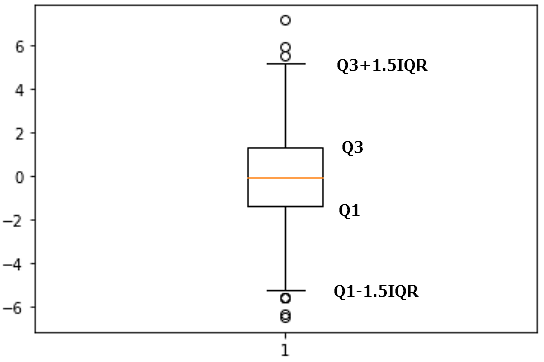

출처: https://seong6496.tistory.com/285

In [18]:
#IQR = Q3- Q1 을 이용하여 이상치의 개수를 구해보기
q3 = df_petition["청원 동의수"].quantile(0.75) 
q1 = df_petition["청원 동의수"].quantile(0.25)

iqr = q3 - q1
out_cut = iqr * 1.5

# lower , upper bound
lower , upper = q1 - out_cut , q3 + out_cut

out_agree1 = df_petition["청원 동의수"] > upper
out_agree2 = df_petition["청원 동의수"] < lower
count_true = sum(out_agree1) + sum(out_agree2)

print(f"총 이상치의 개수는 {count_true}개 입니다.")

총 이상치의 개수는 59개 입니다.


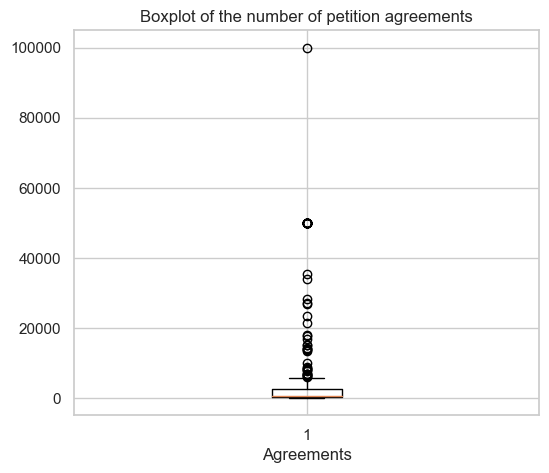

In [25]:
# boxplot으로 시각화해보기
%matplotlib inline 

plt.figure(figsize=(6,5))
plt.boxplot(df_petition["청원 동의수"])
plt.xlabel('Agreements')
plt.title('Boxplot of the number of petition agreements')
plt.show()

## 이상치 처리
- 🐰 청원 동의수가 50000개가 되면 청원 성립이 되기 때문에 50000보다 클 수 없음
- 🐰 100000개의 값이 하나 있으므로 분석을 하기 위해선 이를 50000으로 변경해줘야한다.

In [26]:
# 청원 동의수 100000 → 50000으로 변경
df_petition.loc[df_petition["청원 동의수"]== 100000, "청원 동의수"] = 50000

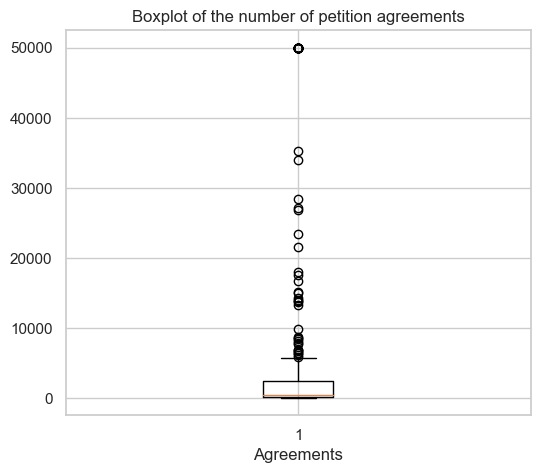

In [27]:
# 100000의 값이 boxplot에서 사라졌음을 확인할 수 있다.
plt.figure(figsize=(6,5))
plt.boxplot(df_petition["청원 동의수"])
plt.xlabel('Agreements')
plt.title('Boxplot of the number of petition agreements')
plt.show()

##  결측값 확인

In [37]:
# null값이 있는 경우를 count 시켜줌. → 없음
df_petition.isnull().sum()

청원인        0
청원명        0
청원의 취지     0
청원의 내용     0
청원분야       0
청원결과       0
청원종료일      0
청원동의시작일    0
청원동의종료일    0
청원 동의수     0
dtype: int64

## 중복값 확인


In [29]:
df_petition[df_petition.duplicated()] # 중복값 없음

,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일,청원 동의수


# 데이터 시각화

🐰 히스토그램

<Figure size 600x500 with 0 Axes>

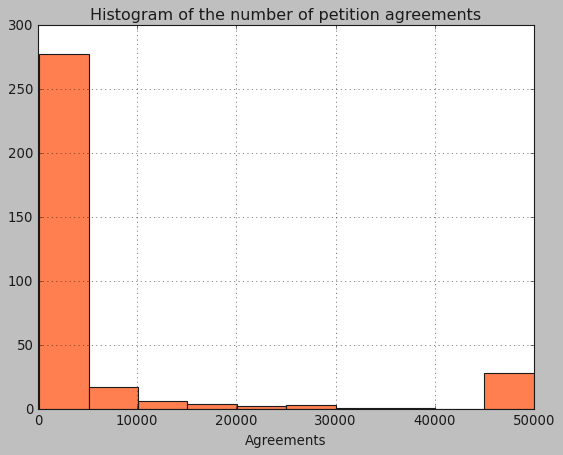

In [35]:
plt.figure(figsize=(6,5))
plt.style.use('classic') # 스타일서식 지정
df_petition.hist(color='coral')
plt.title('Histogram of the number of petition agreements')
plt.xlabel('Agreements')
plt.show()

Text(0, 0.5, '')

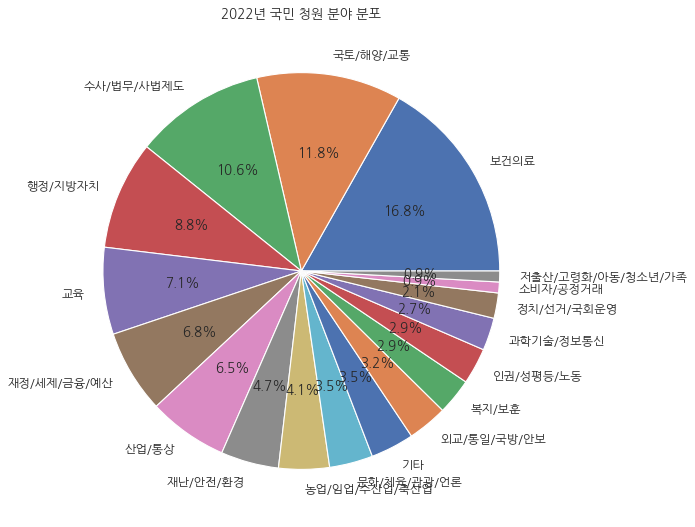

In [44]:
# 원그래프 (지원님 code) 
sns.set(font="NanumGothic")

df_petition['청원분야'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8, 8))
plt.title('2022년 국민 청원 분야 분포')
plt.ylabel('')

#  데이터 분석

##  2022년도 청원들 중에 성립된 청원은 어떤것인지 찾아보기

In [45]:
# 동의수 == 50000건이면 국민청원이 성립된다.
df_yes = df_petition.loc[df_petition['청원 동의수'] == 50000]
df_yes

,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일,청원 동의수
3,이**,연쇄 성범죄자 수원발발이 박○○의 퇴거를 강력히 촉구합니다에 관한 청원,저는 경기도 화성시 봉담읍 수기초등학교 운영위원장 입니다\r\n\r\n연쇄성범죄자...,- 10월 28일(금) 성범죄자의 어머니(수원 호매실 거주)께서 봉담읍 원룸촌에서 ...,수사/법무/사법제도,위원회심사,2022-12-05 07:03:56,2022-11-08 15:46:37,2022-12-05 07:03:56,50000
2,윤**,언론자유와 공영방송의 정치적 독립을 위한 법률 개정에 관한 청원,"최근 윤석열 대통령의 비속어,욕설 파문 이후 집권 세력에 의한 언론자유 탄압과 방송...",1. 현황\r\n○ 한국의 공영방송은 역사적으로 제도권 정치의 권력 향배에서 자유롭...,과학기술/정보통신,본회의불부의,2022-11-18 09:22:24,2022-10-20 17:51:19,2022-11-18 09:22:24,50000
7,박**,XLH저인산혈증구루병 치료제 크리스비타의 신속 사용 승인에 관한 청원,XLH 염색체 우성 저 인산 혈증은 인구 2-6만 명 당 1명에 발생하는 유전성 희...,"“엄마, 하루만이라도 아프지 않고 죽는 게 내 소원이야. 내가 이 말 하면 엄마가 ...",보건의료,위원회심사,2022-11-14 13:36:47,2022-10-17 17:42:33,2022-11-14 13:36:47,50000
1,유**,모든 노동자의 노동권 보장을 위한 노조법 2조·3조 개정에 관한 청원,"헌법 제33조는 단결권, 단체교섭권, 단체행동권을 명시하고 있습니다. 대우조선해양은...","1. 현행 노조법의 문제점\r\n- 특수고용 노동자들은 합법적인 노조인데도, 노조법...",인권/성평등/노동,위원회심사,2022-11-08 21:02:35,2022-11-01 08:58:25,2022-11-08 21:02:35,50000
2,김**,이태원 사고 관련 상황의 세금 사용에 관한 법률 개정에 관한 청원,"이태원 사고는 그 유가족에게는 슬프고, 참사라고 할 수 있겠으나 이런 대규모 인원의...",이태원 사고의 경우 정부에서 장례비용과 치료비용을 지원한다는 기사를 접하고 나의 세...,재난/안전/환경,위원회심사,2022-11-06 11:13:01,2022-10-31 17:00:50,2022-11-06 11:13:01,50000
5,김**,접근금지와 심신미약에 관한 법 강화에 관한 청원,2022년10월4일에 일어난 가정폭력 살인사건에 관련하여 접근금지와 심신미약에 관한...,10월 4일에 일어난 서산 가정폭력 살인사건에 당사자의 아들입니다.저희 엄마의 억울...,수사/법무/사법제도,위원회심사,2022-11-05 04:16:53,2022-10-14 09:45:14,2022-11-05 04:16:53,50000
0,전**,명분도 없고 실익도 없는 금융투자소득세에 대해 반드시 유예해줄 것에 관한 청원,지금 한국증시에 금융투자소득세(이하 금투세)를 도입하는 것은 명분도 실익도 없습니다...,그 이유로 가장 중요한 첫째는 한국증시는 양도소득을 과세할 수 있는 자격이 없다는 ...,재정/세제/금융/예산,위원회심사,2022-10-26 21:01:17,2022-10-12 15:54:48,2022-10-26 21:01:17,50000
1,석**,공무원연금 소득공백 해소 및 온전한 퇴직금 보장에 관한 청원,공무원연금법의 정년과 연금수급 시기 불일치로 인한 소득공백이 발생한 문제점을 해소하...,1. 공무원연금법 제43조(퇴직연금 또는 퇴직연금일시금 등) 제1항 개정 \n - ...,행정/지방자치,위원회심사,2022-10-20 08:22:20,2022-10-18 09:07:42,2022-10-20 08:22:20,50000
5,김**,"온라인, 패키지, 콘솔, 모바일 등 게임물에 대한 사전심의의무 폐지에 관한 청원",헌법 제21조 ①모든 국민은 언론ㆍ출판의 자유와 집회ㆍ결사의 자유를 가진다.\r\n...,2005년 바다이야기 사태 이후 출범한 게임물등급위원회→현 게임물관리위원회는 출범 ...,문화/체육/관광/언론,위원회심사,2022-10-13 20:39:24,2022-10-07 17:49:14,2022-10-13 20:39:24,50000
1,이**,신규 석탄발전소 철회를 위한 탈석탄법 제정에 관한 청원,기후위기 대응에 역행하는 석탄발전소 건설 사업의 취소를 위한 법제화 요구,올 여름 전국을 침수시킨 집중호우의 또 다른 이름은 ‘기후위기’입니다. 턱 밑까지 ...,산업/통상,위원회심사,2022-09-29 21:26:31,2022-08-31 09:07:10,2022-09-29 21:26:31,50000


## 성립된 청원들 중에 어느 분야에서 청원이 가장 많이 성립되었을까?

- 1위 : 수사/ 법무/사법제도 (6개)
- 2위 : 인권/ 성평등/ 노동 (5개)
- 3위 : 보건의료 (4개)

In [60]:
# 청원분야와 청원결과의 교차표(crosstable) 만들기
pd.crosstab(df_yes["청원분야"],df_yes["청원결과"])

청원결과,본회의불부의,위원회심사,위원회접수후철회
청원분야,,,
과학기술/정보통신,1,0,0
농업/임업/수산업/축산업,0,1,0
문화/체육/관광/언론,0,1,0
보건의료,0,4,0
산업/통상,0,3,0
수사/법무/사법제도,0,6,0
인권/성평등/노동,0,5,0
재난/안전/환경,0,1,0
재정/세제/금융/예산,0,1,0


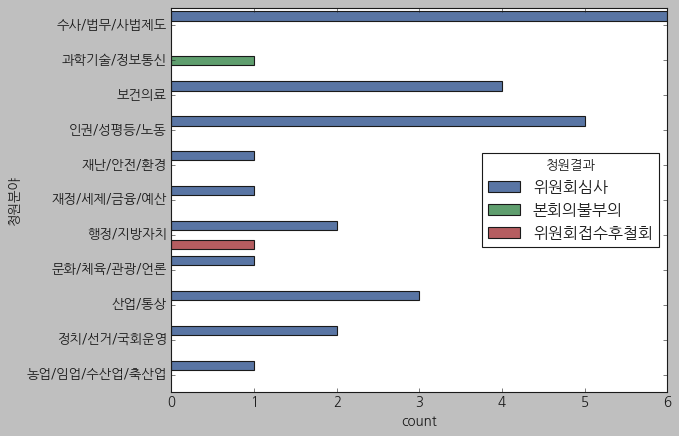

In [61]:
sns.countplot(y=df_yes["청원분야"], hue=df_yes["청원결과"], data=df_yes)
plt.show()

## 2022년도 청원들 중에 미성립된 청원은 어떤것인지 찾아보기

In [62]:
# 동의수 < 50000건이면 국민청원이 성립되지 않는다.
df_no = df_petition.loc[df_petition['청원 동의수'] < 50000]
df_no

,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일,청원 동의수
0,이**,"인천 미추홀구뿐만 아니라 전국적인 ‘나 홀로 아파트, 빌라’ 전세사기에 관한 청원",저는 전세사기 피해자입니다.\r\n\r\n전국적으로 발생한 전세사기 피해에 대한 현...,○ 문제점\r\n낙찰자가 생겨 곧 퇴거해야하는 피해자들을 위한 ‘전세사기피해지원센터...,국토/해양/교통,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:52:01,2022-12-30 23:59:59,2250
1,최**,"모든 학원, 상가 복도 cctv 의무화에 관한 청원",CCTV없는곳에서 일어나는 폭력을 막아주세요.,안녕하세요.\n봉담읍에 사는 초등학생 아이를 둔 엄마입니다.\n저희아이는 학원강의...,국토/해양/교통,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:53:21,2022-12-30 23:59:59,283
2,송**,간호법 제정에 관한 청원,"'간호법' 제정을 통해 간호사의 영역과 업무 범위를 명확화 하고, 간호 서비스 개선...","현재 96개국에 '간호법'이 있고, OECD 국가 38개국 중 미국을 포함한 33개...",보건의료,동의만료폐기,2022-12-31 00:01:00,2022-11-30 09:52:59,2022-12-30 23:59:59,177
3,박**,난치성 편두통 환자를 위한 CGRP 표적 치료제의 급여혜택 강화 촉구에 관한 청원,WHO에서는 세계에서 두번째로 질병 부담이 높은 질환이 편두통이라고 발표했습니다. ...,"건강보험심사평가원에서 공개한 고시 자료[1]를 보면 대상 질환의 특성으로서 ""삽화편...",보건의료,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:39:49,2022-12-28 23:59:59,524
4,최**,가상자산 위믹스 코인 거래지원종료에 관한 DAXA의 처리 투명성과 갑질논란에 관한 청원,한국거래소협회 DAXA에 의한 위믹스코인 거래지원 종료에 대한 투명성 조사와 갑질 ...,한국 거래소협회 DAXA는 10월27일 계획유통량과 실제유통량의 차이를 원인으로 삼...,재정/세제/금융/예산,동의만료폐기,2022-12-29 00:01:00,2022-11-28 16:40:33,2022-12-28 23:59:59,6165
...,...,...,...,...,...,...,...,...,...,...
5,조**,농림축산식품부의 고양이 중성화사업 실시 요령 고시 개정에 관한 청원,청원의 취지자는 수년 간 반려동물들과 함께 살며 길고양이들을 관리해 온 사람입니다....,본 청원의 고시내용 철회를 요청하는 내용에 대해 말씀드리겠습니다.\n\n1.\n『제...,기타,동의만료폐기,2022-01-17 00:01:00,2021-12-17 09:54:22,2022-01-16 23:59:59,313
6,최**,양승태 전 대법원장 재임기간 중의 사법농단 의혹사건 피해자 구제를 위한 특별법안 제...,양승태 전 대법원장 체제하에서의 대법원이 상고 법원 설치 등 특정 목적을 관철 시...,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다.\n1. “사법농단피해자...,수사/법무/사법제도,동의만료폐기,2022-01-13 00:01:00,2021-12-13 17:47:48,2022-01-12 23:59:59,429
7,조**,n번방 방지법인 전기통신사업법 개정안의 재개정에 관한 청원,"헌법 제 18조를 위배하며, 법의 효율성이 의심되는 해당 개정안에 대한 개정을 바람","먼저, 해당 개정안은 헌법 제18조를 위배할 우려가 큽니다. ""모든 국민은 통신의 ...",과학기술/정보통신,동의만료폐기,2022-01-13 00:01:00,2021-12-13 17:49:00,2022-01-12 23:59:59,1853
0,윤**,수개표로 전환 안심 선거에 관한 청원,안녕하십니까? \n\n공직선거에서 전자개표가 도입된 이래 끊임없이 부정선거의 논란이...,1. ‘당일 투표’를 기본 원칙으로 한다.\n\n부정선거의 가능성이 높은 사전투표와...,정치/선거/국회운영,동의만료폐기,2022-01-07 00:01:00,2021-12-07 16:21:09,2022-01-06 23:59:59,3034


##  미성립된 청원들 중에 어느 분야의 청원이 많을까?
- 1위 : 보건의료 (53개)
- 2위 : 국토/해양/교통(40개)
- 3위 : 수사/법무/사법제도(30개)

In [64]:
# 청원분야와 청원결과의 교차표(crosstable) 만들기
pd.crosstab(df_no["청원분야"],df_no["청원결과"])

청원결과,동의만료폐기
청원분야,
과학기술/정보통신,8
교육,24
국토/해양/교통,40
기타,12
농업/임업/수산업/축산업,13
문화/체육/관광/언론,11
보건의료,53
복지/보훈,10
산업/통상,19


##  미성립된 청원들 중에 동의수를 가장 많이 받은 Top 3 게시물

In [65]:
df_no.sort_values("청원 동의수",ascending = False).head(3)

,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일,청원 동의수
2,김**,"구멍 뚫린 GMO수입검역체계 OUT, 유전자변형생물체의국가간이동등에관한법률의 개정에...",▶전 세계 약 180개 국가는 GMO의 인체 ·환경 피해를 사전방지하기 위해 공동의...,1996년 GMO가 처음 상업화된 후 30년 가까운 시간이 흘렀어도 논쟁이 계속되고...,산업/통상,동의만료폐기,2022-10-24 00:01:00,2022-09-23 14:07:08,2022-10-23 23:59:59,35303
4,최**,양승태 전 대법원장 재임기간 중의 사법농단 의혹사건 피해자 구제를 위한 특별법안 제...,양승태 전 대법원장 체제하에서의 대법원이 상고 법원 설치 등 특정 목적을 관철 시...,제2조(정의) 이 법에서 사용하는 용어의 뜻은 다음과 같다.\n1. “사법농단피해자...,수사/법무/사법제도,동의만료폐기,2022-05-21 00:01:00,2022-04-20 17:34:56,2022-05-20 23:59:59,34004
5,박**,"1,400만명 개인주주를 절망에 빠트리고 건전한 자본시장을 좀먹는 공매도의 한시적 ...",1) 본 청원은 우리 증시를 글로벌 증시 대비 과도하게 하락한 상황이 정상화될 때까...,현재 우리나라 증시는 공매도 세력들의 놀이터가 되어버렸습니다. 우리나라 공매도 거래...,재정/세제/금융/예산,동의만료폐기,2022-12-01 00:01:00,2022-10-31 17:00:18,2022-11-30 23:59:59,28405


##  미성립된 청원들 중에 동의수를 가장 적게 받은 Top 3 게시물

- 3개 다 국토/해양/교통 분야의 청원이다.

In [66]:
df_no.sort_values("청원 동의수",ascending = True).head(3)

,청원인,청원명,청원의 취지,청원의 내용,청원분야,청원결과,청원종료일,청원동의시작일,청원동의종료일,청원 동의수
3,김**,지방도 확포장공사 피해사실에 관한 청원,재산권 침해하는 지자체,"안녕하세요, 수고가 많으십니다.\r\n 다름이 아니라 너무나도 억울하고 답답하...",국토/해양/교통,동의만료폐기,2022-12-17 00:01:00,2022-11-16 11:25:49,2022-12-16 23:59:59,108
2,안**,세마역 주변 소음 방지를 위한 해결 방안 요청 건.에 관한 청원,세마역 주변에 지하철 및 기차등으로 인해 소음이 심합니다. 이에 철도공사측은 주변 ...,세마역 근처 건물에 직장인 입니다. 전철역이 있어 출퇴근 하는 편리 합니다. \r\...,국토/해양/교통,동의만료폐기,2022-08-26 00:01:00,2022-07-26 18:14:06,2022-08-25 23:59:59,114
6,김**,부천 지하실 침수피해에 관한 청원,신축 건물로 인해 지하실 피해을 한달데 5번 이나 침수 됐는데 부천시청에서는 민...,부천시장님 안녕하십니까? \r\n 당사는 (주) 씨디 종합건설이 신축중인 건물 아...,국토/해양/교통,동의만료폐기,2022-10-30 00:01:00,2022-09-29 17:44:44,2022-10-29 23:59:59,115
